In [24]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import panda_gym

In [25]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [26]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("PandaPush-v3")
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

pybullet build time: Mar 15 2024 19:42:25


argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


In [28]:
# Create action noise because TD3 and DDPG use a deterministic policy
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = TD3('MultiInputPolicy', env, action_noise=action_noise, verbose=0)
# Train the agent
model.learn(total_timesteps=int(1e3), callback=callback)

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -45.24
Saving new best model to /tmp/gym/best_model.zip


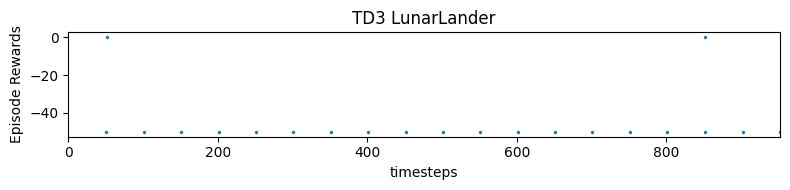

In [29]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "TD3 LunarLander"
)

In [30]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    #y = moving_average(y, window=50)
    # Truncate x
    #x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

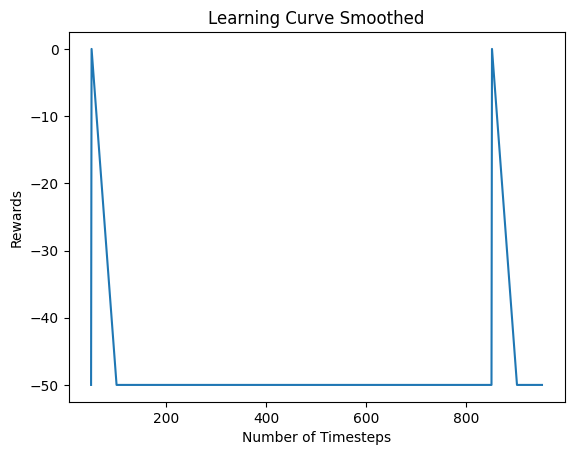

In [31]:
plot_results(log_dir)